# Test de Kolmogorov-Smirnov et la loi de Benford

notebook pour tester le test de Kolmogorov-Smirnov et l'implémenter au module pybenford

## Implémentation du test de K-S

In [1]:
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt

In [2]:
#generate random aray
arr_1 = np.random.normal(0, 1.0, size=100)
#print(arr_1)

#edf
arr_1_edf = np.arange(1/len(arr_1), 1+1/len(arr_1), 1/len(arr_1))
#print(arr_1_edf)

#sort generated array
arr_1_sorted = np.sort(arr_1)
#print(arr_1_sorted)

#get cdf based on norm distribution
cdf_null_hyp = [st.norm.cdf(x) for x in arr_1_sorted]
#print(cdf_null_hyp)

#calculate absolute difference
arr_dif_abs = np.abs(cdf_null_hyp-arr_1_edf)
#print(arr_dif_abs)

#get max difference
dn_ks = max(arr_dif_abs)
#print(dn_ks)

In [3]:
st.kstest(arr_1, 'norm')

KstestResult(statistic=0.08648968707232824, pvalue=0.41933193144147285)

### Avec données d'abondance de protéines

In [4]:
import pybenford as ben
import numpy as np
import pandas as pd

In [5]:
data = pd.read_csv('data_abundance_analysis/1512006-Calbicans-QUANTI.csv', skiprows=2)

In [6]:
normalized_columns = ['1512006-1', '1512006-7', '1512006-2', '1512006-8',
                      '1512006-3', '1512006-9', '1512006-4', '1512006-10',
                      '1512006-5_150410082104', '1512006-11',
                      '1512006-6_150410115425', '1512006-12']

In [7]:
norm_abundance = data[normalized_columns]
print(norm_abundance.shape)
# données dans un array d'une dimmenssion
norm_abundance = norm_abundance.values.reshape(norm_abundance.shape[0] * norm_abundance.shape[1])
print(norm_abundance.shape)
# remove 0
norm_abundance = norm_abundance[norm_abundance > 0]
print(norm_abundance.shape)

(2566, 12)
(30792,)
(26936,)


In [8]:
first_digit = ben.count_first_digit(norm_abundance)
print(first_digit)

[8073 4633 3258 2583 2201 1861 1534 1504 1274]


In [9]:
freq_obs = ben.normalize_first_digit(first_digit)
print(freq_obs)

[0.29987742 0.17209613 0.12102076 0.0959474  0.08175774 0.06912819
 0.05698154 0.05586717 0.04732365]


In [10]:
def cdf(freq_obs):
    freq_obs_cumul = np.zeros(len(freq_obs), dtype=float)
    cumul = 0
    for i in range(len(freq_obs)):
        cumul += freq_obs[i]
        freq_obs_cumul[i] = cumul
    return freq_obs_cumul

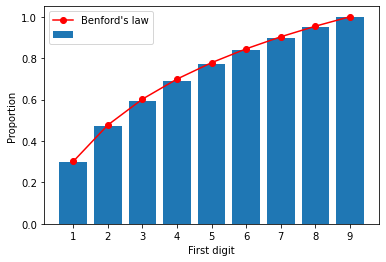

In [11]:
ben.build_hist_freq_ben(cdf(freq_obs), cdf(ben.get_theoretical_freq_benford()), 1);

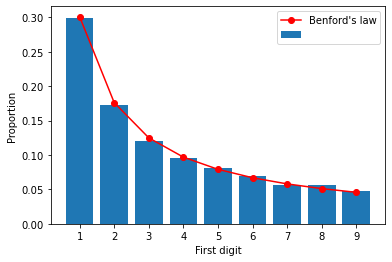

In [12]:
ben.build_hist_freq_ben(freq_obs, ben.get_theoretical_freq_benford(), 1);

In [13]:
# calculate absolute difference
arr_diff_abs = np.abs(cdf(ben.get_theoretical_freq_benford()) - cdf(freq_obs))
print(arr_diff_abs)

[1.15257655e-03 5.14770247e-03 9.06567462e-03 1.00282860e-02
 7.45179643e-03 5.27039617e-03 6.28080457e-03 1.56616012e-03
 1.11022302e-16]


In [14]:
# get max difference
max_diff = max(arr_diff_abs)
print(max_diff)

0.01002828597488803


In [15]:
# calculate critical value
ks_crit = 1.36/(np.sqrt(sum(first_digit)))
print(ks_crit)

0.008288831561233218


In [16]:
if max_diff < ks_crit:
    print(f"Non rejet de H0, l'enssemble de nombre suit la loi de Benford",
          f" pour un risque alpha de 0.05")
else:
    print(f"Rejet de H0, l'enssemble de nombre ne suit pas la loi de Benford",
          f" pour un risque alpha de 0.05")

Rejet de H0, l'enssemble de nombre ne suit pas la loi de Benford  pour un risque alpha de 0.05


In [17]:
# Function K-S test of pybenford module
ben.ks_test(freq_obs, ben.get_theoretical_freq_benford(), sum(first_digit))

Not conform to Benford law, for alpha risk = 5%



(0.01002828597488803, 0.008288831561233218)

In [18]:
%%time
# Bootstrap for K-S test
ben.calculate_bootstrap_ks(norm_abundance, ben.get_theoretical_freq_benford(), 1)

Comform to Benford law, for alpha risk = 5%

CPU times: user 2.65 s, sys: 0 ns, total: 2.65 s
Wall time: 2.65 s


(0.021916777910165604, 0.04300697617828996)

### utilisation de KS_2samp de scipy.stats

In [19]:
st.kstest(first_digit, (ben.get_theoretical_freq_benford()))

KstestResult(statistic=1.0, pvalue=4.11353352529823e-05)

In [20]:
st.ks_2samp(first_digit, (ben.get_theoretical_freq_benford()*sum(first_digit)))

KstestResult(statistic=0.1111111111111111, pvalue=1.0)

In [21]:
def get_list_first_digit(array_first_digit):
    list_nb = []
    for i in range(len(first_digit)):
        for j in range(first_digit[i]):
            list_nb.append(i+1)
    print(len(list_nb)); print(sum(first_digit))
    return list_nb

In [22]:
list_first_digit = get_list_first_digit(first_digit)
list_fist_digit_theo = get_list_first_digit(ben.normalize_first_digit(
    ben.get_theoretical_freq_benford()))

26921
26921
26921
26921


In [23]:
st.ks_2samp(list_first_digit, list_fist_digit_theo)

KstestResult(statistic=0.0, pvalue=1.0)

## Protéines total de SwissProt

In [24]:
data2 = pd.read_csv("tests/Prot_tot_uniprot/uniprot-reviewed yes.tab", sep = "\t" , index_col = 0)

In [25]:
d_obs = ben.count_first_digit(data2["Entry Length"])
print(d_obs)
freq_obs = ben.normalize_first_digit(d_obs)
print(freq_obs)

[138907 115221 102958  71941  42418  30877  22501  21311  18504]
[0.24601072 0.20406172 0.18234338 0.12741084 0.07512424 0.05468459
 0.03985031 0.03774277 0.03277144]


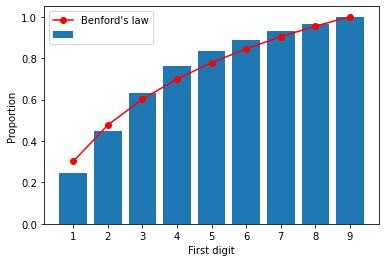

In [26]:
ben.build_hist_freq_ben(cdf(freq_obs), cdf(ben.get_theoretical_freq_benford()), 1);

In [27]:
# calculate absolute difference
arr_diff_abs = np.abs(cdf(ben.get_theoretical_freq_benford()) - cdf(freq_obs))
print(arr_diff_abs)

[5.50192773e-02 2.70488189e-02 3.03558220e-02 6.08566457e-02
 5.67996385e-02 4.45374433e-02 2.63958074e-02 1.29860512e-02
 1.11022302e-16]


In [28]:
# get max difference
max_diff = max(arr_diff_abs)
print(max_diff)

0.06085664565919946


In [29]:
# calculate critical value
ks_crit = 1.36/(np.sqrt(sum(d_obs)))
print(ks_crit)

0.0018098969868555624


In [30]:
if max_diff < ks_crit:
    print(f"Non rejet de H0, l'enssemble de nombre suit la loi de Benford",
          f" pour un risque alpha de 0.05")
else:
    print(f"Rejet de H0, l'enssemble de nombre ne suit pas la loi de Benford",
          f" pour un risque alpha de 0.05")

Rejet de H0, l'enssemble de nombre ne suit pas la loi de Benford  pour un risque alpha de 0.05


In [31]:
# Function K-S test of pybenford module
ben.ks_test(freq_obs, ben.get_theoretical_freq_benford(), sum(d_obs))

Not conform to Benford law, for alpha risk = 5%



(0.06085664565919946, 0.0018098969868555624)

In [32]:
%%time
# Bootstrap for K-S test
ben.calculate_bootstrap_ks(data2["Entry Length"], ben.get_theoretical_freq_benford(), 1)

Not conform to Benford law, for alpha risk = 5%

CPU times: user 11.1 s, sys: 3.56 ms, total: 11.1 s
Wall time: 11.1 s


(0.06775674537728456, 0.04300697617828996)

In [33]:
st.kstest(d_obs, (ben.get_theoretical_freq_benford()*sum(d_obs)))

KstestResult(statistic=0.3333333333333333, pvalue=0.7301110654051831)

In [34]:
st.ks_2samp(d_obs, (ben.get_theoretical_freq_benford()*sum(d_obs)))

KstestResult(statistic=0.3333333333333333, pvalue=0.7301110654051831)

In [35]:
list_first_digit = get_list_first_digit(d_obs)
list_fist_digit_theo = get_list_first_digit(ben.normalize_first_digit(
    ben.get_theoretical_freq_benford()))

26921
26921
26921
26921


In [36]:
st.ks_2samp(list_first_digit, list_fist_digit_theo)

KstestResult(statistic=0.0, pvalue=1.0)